In [2]:
import cv2 as cv
import os
os.environ['OPENCV_IO_ENABLE_OPENEXR'] = '1'
import numpy as np
import open3d as o3d
import json

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
###########################################
# Fn coverts a distance image from blender EXR 
# where dist is measured from the camera to a 
# depth image where there in no angular bias
###########################################

def dist2depth_img(dist_img, focal =3500):
    img_width = dist_img.shape[1]
    img_height = dist_img.shape[0]

    cx = img_width // 2
    cy = img_height// 2

    xs = np.arange(img_width) - cx
    ys = np.arange(img_height) - cy
    xis, yis = np.meshgrid(xs, ys)
    depth = np.sqrt(dist_img**2 / ((xis**2 + yis**2)/ (focal**2) +1))

    return depth.astype(np.float32)

In [3]:
fs = cv.FileStorage('Q_12_7.yaml', cv.FILE_STORAGE_READ)
Q = fs.getNode('Q').mat()
print("Loaded Q:\n", Q)
# Release the FileStorage object
fs.release()

Loaded Q:
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  3.13957336e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -3.55971863e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.53731922e+03]
 [ 0.00000000e+00  0.00000000e+00  1.86458848e+01  2.21144669e+04]]


In [9]:
############################################
# Import camera calibration data
# from calib.io program via json
#############################################
with open('/home/jacob/Snake2TB/endo_calib/low_cost_proj/8_11_2x/low_cost_dual_Charuco.json', 'r') as file:
    calib = json.load(file)

sensor_width_mm = 8.8
sensor_height_mm = 6.6
sensor_width_px = 640
sensor_height_px = 480

left_cam_model = calib["Calibration"]["cameras"][0]["model"]["ptr_wrapper"]["data"]["parameters"]
left_cam_f_px = left_cam_model["f"]["val"]
left_cam_cx_px = left_cam_model["cx"]["val"]
left_cam_cy_px = left_cam_model["cy"]["val"]
left_cam_f_mm = left_cam_f_px * (sensor_width_mm / sensor_width_px)
left_shift_x = (left_cam_cx_px - sensor_width_px / 2) / sensor_width_px
left_shift_y = (left_cam_cy_px - sensor_height_px /2) / sensor_height_px


right_cam_model = calib["Calibration"]["cameras"][1]["model"]["ptr_wrapper"]["data"]["parameters"]
right_cam_f_px = right_cam_model["f"]["val"]
right_cam_cx_px = right_cam_model["cx"]["val"]
right_cam_cy_px = right_cam_model["cy"]["val"]
right_cam_f_mm = right_cam_f_px * (sensor_width_mm / sensor_width_px)
right_shift_x = (right_cam_cx_px - sensor_width_px / 2) / sensor_width_px
right_shift_y = (right_cam_cy_px - sensor_height_px /2) / sensor_height_px


extrinsics = calib["Calibration"]["cameras"][1]["transform"]
rot = extrinsics["rotation"]
rx = rot['rx']
ry = rot['ry']
rz = rot['rz']
trans = extrinsics["translation"]
tx = trans['x']*1000
ty = trans['y']*1000
tz = trans['z']*1000

print('left camera focal length:', left_cam_f_px)
print('left vamera focal length in mm:', left_cam_f_mm)
print('baseline in mm:', tx)

left camera focal length: 3526.854419933091
left vamera focal length in mm: 48.49424827408001
baseline in mm: -0.05280316689838094


In [12]:
tx


-0.05280316689838094

In [4]:
file_L = cv.imread("/home/jacob/Snake2TB/Blender_bin/Endo_scans/stereo_test_images_jan_23/depth_000005_L.exr", cv.IMREAD_ANYCOLOR | cv.IMREAD_ANYDEPTH)
file_R = cv.imread("/home/jacob/Snake2TB/Blender_bin/Endo_scans/stereo_test_images_jan_23/depth_000005_R.exr", cv.IMREAD_ANYCOLOR | cv.IMREAD_ANYDEPTH)

gray_image_L = cv.cvtColor(file_L, cv.COLOR_BGR2GRAY)
gray_image_R = cv.cvtColor(file_R, cv.COLOR_BGR2GRAY)

In [6]:
cv.imshow('img', gray_image_L)

In [8]:
gray_image_L.shape

(480, 640)

: 

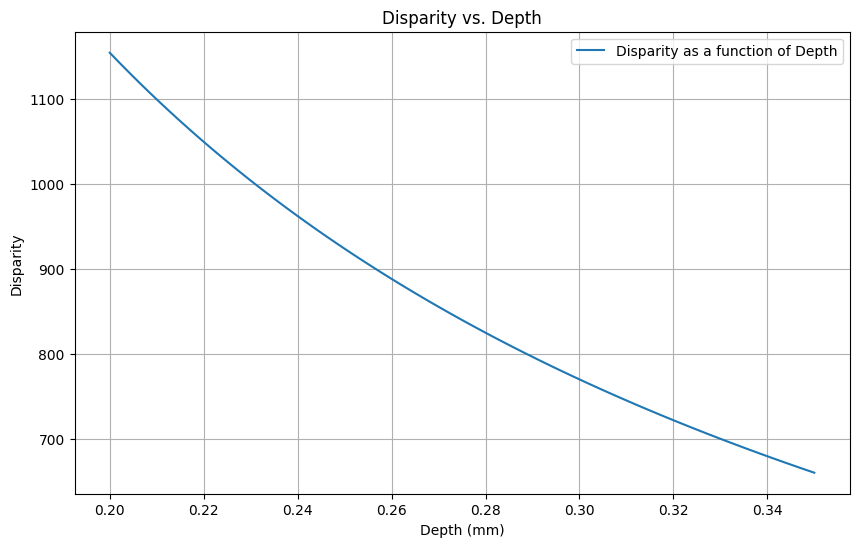

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def disparity_from_depth(depth):
    """
    Calculate disparity from depth using the formula d = 231000 / z.
    
    Args:
    - depth (float or numpy array): Depth value(s)
    
    Returns:
    - float or numpy array: Disparity value(s)
    """
    return 3500*.066 / depth

# Generate depth values in the range [0, 350]
depth_values = np.linspace(.200, .350, 100)  #
# Calculate corresponding disparity values
disparity_values = disparity_from_depth(depth_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(depth_values, disparity_values, label='Disparity as a function of Depth')
plt.xlabel('Depth (mm)')
plt.ylabel('Disparity')
plt.title('Disparity vs. Depth')
plt.grid(True)
plt.legend()
plt.show()